In [1]:
from utils import *
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

In [2]:
OK_img, NG_img, NG_labels = gen_dataset()
print('缺陷图倾斜校正:')  # 做倾斜校正
for i, img in enumerate(NG_img):  # 判断NG图
    # 倾斜矫正
    label = NG_labels[i]
    img = 255 - img
    img_thres = cv2.Canny(img, 100, 200)
    ok_img, label, angle = tile_correction_2(img_thres, img, label)  # 倾斜校正函数
    # cv2.imshow('',ok_img)
    # cv2.waitKey(-1)
    # cv2.destroyAllWindows()
    label[label > 0] = 255
    ok_img = cv2.resize(ok_img, (800, 600))
    label = cv2.resize(label, (800, 600))
    NG_img[i] = ok_img
    NG_labels[i] = label
    print(f'{i}\t旋转{angle}度')

print('无缺陷图倾斜校正:')
for i, img in enumerate(OK_img):  # 处理OK图
    # 倾斜矫正
    img = 255 - img
    img_thres = cv2.Canny(img, 100, 200)
    ok_img, angle = tile_correction_2(img_thres, img)
    ok_img = cv2.resize(ok_img, (800, 600))
    OK_img[i] = ok_img
    print(f'{i}\t旋转{angle}度')

save('data/defect_correctedEdge/OK_img.pickle', OK_img)
save('data/defect_correctedEdge/NG_img.pickle', NG_img)
save('data/defect_correctedEdge/NG_labels.pickle', NG_labels)

缺陷图倾斜校正:
0	旋转88.5度
1	旋转88.2度
2	旋转88.4度
3	旋转88.1度
4	旋转86.8度



KeyboardInterrupt



处理缺陷图...
处理无缺陷图...


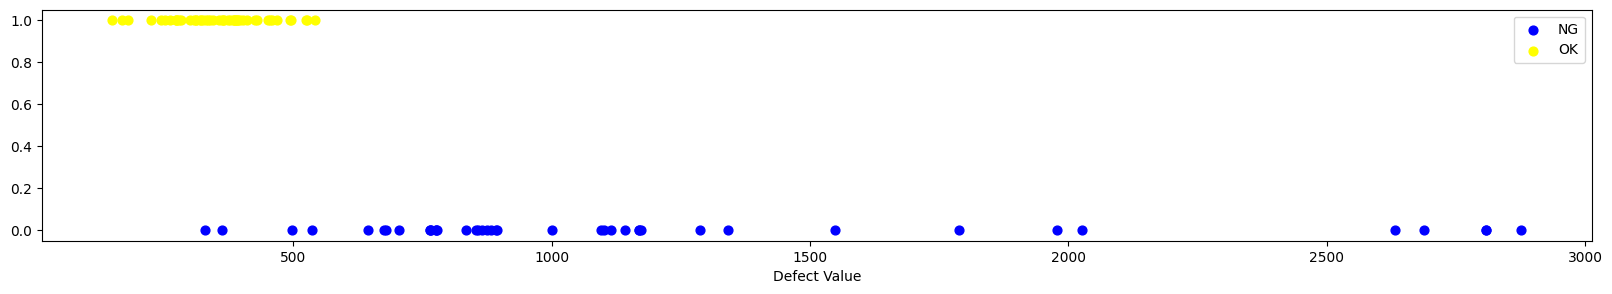

准确度:0.9560439560439561
混淆矩阵:
[[50  0]
 [ 4 37]]


In [3]:
# 图像级别的分类
OK_img = load('data/defect_correctedEdge/OK_img.pickle')
NG_img = load('data/defect_correctedEdge/NG_img.pickle')
NG_labels = load('data/defect_correctedEdge/NG_labels.pickle')
print('处理缺陷图...')
thres = 580
bad_assess_list = []
pred = []
l = [1] * 41 + [0] * 50
detect_list = []
mask_list = []
for i, img in enumerate(NG_img):  # 判断NG图
    fft1, fft2, mask = eliminate_thin_curve(img)
    # cv2.imshow('fft2',fft2)
    fft1[mask > 0] = 0
    fft2[fft2 < 27] = 0
    k = np.ones((4, 4))
    th, fft2_thres = cv2.threshold(cv2.equalizeHist(fft2), 135, 255, cv2.THRESH_BINARY)
    temp = cv2.morphologyEx(fft2_thres, cv2.MORPH_OPEN, k)
    fft2_thres = fft2_thres - temp
    fft2_thres[mask > 0] = 0
    fft2_thres = cv2.morphologyEx(fft2_thres, cv2.MORPH_OPEN, np.ones((2, 2)))
    assess = fft2_thres.sum() / 255
    bad_assess_list.append(assess)
    mask_list.append(mask)
    # cv2.imshow('fft2_thres', fft2_thres)
    # cv2.waitKey(-1)
    # cv2.destroyAllWindows()
    if assess > thres:
        pred.append(1)
        detect_list.append((fft1, NG_labels[i]))
    else:
        pred.append(0)
        detect_list.append((fft1, 0))

print('处理无缺陷图...')
good_assess_list = []
# OK_mask_list = []
for i, img in enumerate(OK_img):  # 处理OK图
    fft1, fft2, mask = eliminate_thin_curve(img)
    # cv2.imshow('fft2',fft2)
    fft1[mask > 0] = 0
    fft2[fft2 < 27] = 0
    k = np.ones((4, 4))
    th, fft2_thres = cv2.threshold(cv2.equalizeHist(fft2), 135, 255, cv2.THRESH_BINARY)
    temp = cv2.morphologyEx(fft2_thres, cv2.MORPH_OPEN, k)
    fft2_thres = fft2_thres - temp
    fft2_thres[mask > 0] = 0
    fft2_thres = cv2.morphologyEx(fft2_thres, cv2.MORPH_OPEN, np.ones((2, 2)))
    assess = fft2_thres.sum() / 255
    good_assess_list.append(assess)
    mask_list.append(mask)
    # cv2.imshow('fft2_thres', fft2_thres)
    # cv2.waitKey(-1)
    if assess > thres:
        pred.append(1)
        detect_list.append((fft1, NG_labels[i]))
    else:
        pred.append(0)
        detect_list.append((fft1, 0))

plt.figure(figsize=(20, 3))
plt.scatter(bad_assess_list, np.zeros_like(bad_assess_list), s=40, alpha=1, c='blue')
plt.scatter(good_assess_list, np.zeros_like(good_assess_list) + 1, s=40, alpha=1, c='yellow')
plt.legend(['NG', 'OK'])
plt.xlabel('Defect Value')
plt.show()

acc = accuracy_score(l, pred)
conf = confusion_matrix(l, pred)
print(f'准确度:{acc}\n混淆矩阵:\n{conf}')

In [7]:
rectangles_list = []
labels_list = []
img_list = []
for i, (img, label) in enumerate(detect_list):
    if type(label) == np.ndarray:  # 在图像层面是否被标识为负样本，是则继续处理
        mask = mask_list[i]
        bn_r = 15
        bn_c = 20
        img_balance, _ = light_balance(img, 80, 60, 150)
        img_balance[mask > 0] = 0
        th, img_thres = cv2.threshold(img_balance, 140, 255, cv2.THRESH_BINARY)
        contrast_threshold = 95
        img_glcm, rectangles = GLCM(img_balance, bn_r, bn_c, contrast_threshold)
        cv2.imwrite(f'data/glcm/glcm_img/{i}.png', img_glcm)
        rectangles_list.append(rectangles)
        labels_list.append(label)
        img_list.append(img)
        # cv2.imshow(f'认为图像{i}存在缺陷, 灰度共生矩阵的对比度', img_glcm)
        # cv2.imshow(f'缺陷的标签', label)
    else:
        # cv2.imshow(f'认为图像{i}不存在缺陷, 图像样例', img)
        pass
    print(f'\r缺陷级别的检测{i + 1}/91', end='\r')
    # cv2.waitKey(-1)
    # cv2.destroyAllWindows()
save('data/detected_rectangle/rectangles_list.pickle', rectangles_list)
save('data/detected_rectangle/labels_list.pickle', labels_list)
save('data/detected_rectangle/img_list.pickle', img_list)

在缺陷层面，检测覆盖率高于0.5的样本数:32/37
在缺陷层面，检测覆盖率高于0的样本数:36/37
在像素层面，检测的像素平均覆盖率:0.18284615261326817


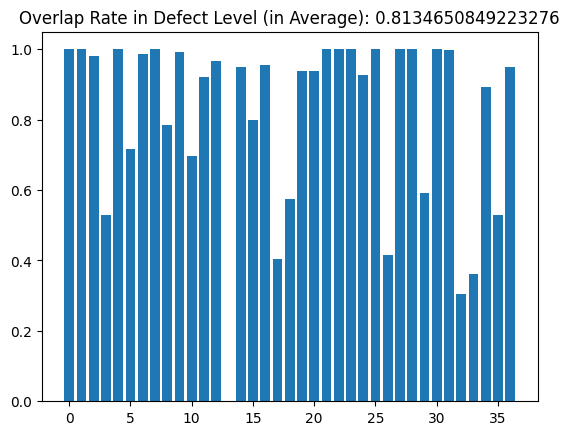

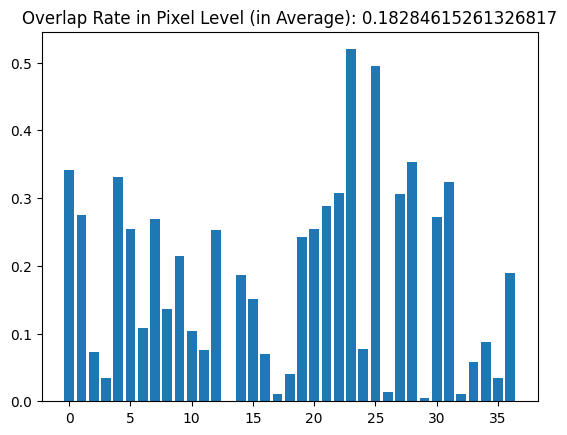

In [4]:
# 像素层面的检测
rectangles_list = load('data/detected_rectangle/rectangles_list.pickle')  # 加载缺陷层面的检测结果
labels_list = load('data/detected_rectangle/labels_list.pickle')
img_list = load('data/detected_rectangle/img_list.pickle')
overlap_rate_list = []
pixel_overlap_rate_list = []
for i, label in enumerate(labels_list):
    rectangles = rectangles_list[i]
    img = img_list[i]
    ol_rate, pol_rate = detect_pixel(img, rectangles, label)
    overlap_rate_list.append(ol_rate)
    pixel_overlap_rate_list.append(pol_rate)
plt.figure()
plt.bar(np.arange(len(overlap_rate_list)), overlap_rate_list)
plt.title(f'Overlap Rate in Defect Level (in Average): {np.mean(overlap_rate_list)}')
plt.figure()
plt.bar(np.arange(len(pixel_overlap_rate_list)), pixel_overlap_rate_list)
plt.title(f'Overlap Rate in Pixel Level (in Average): {np.mean(pixel_overlap_rate_list)}')
print(f'在缺陷层面，检测覆盖率高于0.5的样本数:{np.sum(np.array(overlap_rate_list) > 0.5)}/{len(overlap_rate_list)}')
print(f'在缺陷层面，检测覆盖率高于0的样本数:{np.sum(np.array(overlap_rate_list) > 0)}/{len(overlap_rate_list)}')
print(f'在像素层面，检测的像素平均覆盖率:{np.mean(pixel_overlap_rate_list)}')
